# Pipeline Results Explorer

This notebook allows you to explore results from market pipeline runs.

Each pipeline run creates a timestamped directory in `data/pipelines/` with:
- `results.csv` - Main results table
- `results.json` - Full results with nested data
- `pipeline_config.json` - Configuration used
- `summary.json` - Summary statistics

In [26]:
# Standard library
import sys
sys.path.append('..')
import json
from pathlib import Path
from datetime import datetime

# Third-party
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import make_market


import matplotlib.pyplot as plt
%matplotlib inline

## List Available Pipeline Runs

In [2]:
def list_pipeline_runs(base_dir="../data/pipelines"):
    """
    List all available pipeline runs.
    
    Returns:
        DataFrame with run information
    """
    base_path = Path(base_dir)
    
    if not base_path.exists():
        print(f"Pipeline directory not found: {base_path}")
        return pd.DataFrame()
    
    runs = []
    for run_dir in sorted(base_path.iterdir()):
        if not run_dir.is_dir():
            continue
        
        # Check if it has the expected files
        results_csv = run_dir / "results.csv"
        summary_json = run_dir / "summary.json"
        config_json = run_dir / "pipeline_config.json"
        
        if not results_csv.exists():
            continue
        
        run_info = {
            "run_id": run_dir.name,
            "path": str(run_dir),
            "has_results": results_csv.exists(),
            "has_summary": summary_json.exists(),
            "has_config": config_json.exists(),
        }
        
        # Load summary if available
        if summary_json.exists():
            with open(summary_json) as f:
                summary = json.load(f)
                run_info["n_questions"] = summary.get("n_questions")
                run_info["total_capital"] = summary.get("total_capital")
                run_info["total_allocated"] = summary.get("total_allocated")
        
        # Parse timestamp
        try:
            timestamp = datetime.strptime(run_dir.name, "%Y%m%d_%H%M")
            run_info["timestamp"] = timestamp
            run_info["date"] = timestamp.strftime("%Y-%m-%d")
            run_info["time"] = timestamp.strftime("%H:%M")
        except ValueError:
            run_info["timestamp"] = None
            run_info["date"] = None
            run_info["time"] = None
        
        runs.append(run_info)
    
    if not runs:
        print("No pipeline runs found")
        return pd.DataFrame()
    
    df = pd.DataFrame(runs)
    df = df.sort_values("run_id", ascending=False).reset_index(drop=True)
    return df


# List all available runs
runs_df = list_pipeline_runs()

if len(runs_df) > 0:
    print(f"Found {len(runs_df)} pipeline runs:\n")
    display(runs_df[['run_id', 'date', 'time', 'n_questions', 'total_capital', 'total_allocated']])
else:
    print("No pipeline runs found. Run the pipeline first:")
    print("  python market_pipeline.py")

Found 3 pipeline runs:



,run_id,date,time,n_questions,total_capital,total_allocated
0,20251016_1138,2025-10-16,11:38,4,10000.0,10000.0
1,20251016_1134,2025-10-16,11:34,3,10000.0,10000.0
2,20251016_1126,2025-10-16,11:26,3,10000.0,10000.0


## Load Pipeline Results

Select a run ID from the list above and load its results.

In [3]:
# Select a run to explore
# Change this to any run_id from the list above
RUN_ID = "20251016_1126"  # Example - replace with actual run ID
RUN_ID = "20251016_1138"
# If you want to use the most recent run automatically:
if len(runs_df) > 0:
    RUN_ID = runs_df.iloc[0]['run_id']
    print(f"Using most recent run: {RUN_ID}")
else:
    print("No runs available")

Using most recent run: 20251016_1138


In [4]:
def load_pipeline_run(run_id, base_dir="../data/pipelines"):
    """
    Load all data from a pipeline run.
    
    Args:
        run_id: Run identifier (e.g., "20251016_1126")
        base_dir: Base directory for pipeline outputs
    
    Returns:
        dict with keys: 'results', 'config', 'summary', 'results_json'
    """
    run_dir = Path(base_dir) / run_id
    
    if not run_dir.exists():
        raise ValueError(f"Run directory not found: {run_dir}")
    
    data = {}
    
    # Load results CSV
    results_csv = run_dir / "results.csv"
    if results_csv.exists():
        data['results'] = pd.read_csv(results_csv)
        print(f"✓ Loaded results: {len(data['results'])} questions")
    else:
        print("✗ results.csv not found")
        data['results'] = None
    
    # Load results JSON (has full data including probability samples)
    results_json = run_dir / "results.json"
    if results_json.exists():
        with open(results_json) as f:
            data['results_json'] = json.load(f)
        print(f"✓ Loaded full results JSON")
    else:
        print("✗ results.json not found")
        data['results_json'] = None
    
    # Load config
    config_json = run_dir / "pipeline_config.json"
    if config_json.exists():
        with open(config_json) as f:
            data['config'] = json.load(f)
        print(f"✓ Loaded configuration")
    else:
        print("✗ pipeline_config.json not found")
        data['config'] = None
    
    # Load summary
    summary_json = run_dir / "summary.json"
    if summary_json.exists():
        with open(summary_json) as f:
            data['summary'] = json.load(f)
        print(f"✓ Loaded summary")
    else:
        print("✗ summary.json not found")
        data['summary'] = None
    
    return data


# Load the selected run
print(f"Loading pipeline run: {RUN_ID}\n")
run_data = load_pipeline_run(RUN_ID)

Loading pipeline run: 20251016_1138

✓ Loaded results: 4 questions
✓ Loaded full results JSON
✓ Loaded configuration
✓ Loaded summary


## View Results DataFrame

In [5]:
# Display the results dataframe
df = run_data['results']

if df is not None:
    print(f"Pipeline Results for {RUN_ID}")
    print(f"{'='*80}\n")
    print(f"Total questions: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nDataFrame shape: {df.shape}")
    print(f"\nFirst few rows:\n")
    display(df.head())
else:
    print("No results available")

Pipeline Results for 20251016_1138

Total questions: 4
Columns: ['topic', 'question', 'resolution_date', 'resolution_criteria', 'estimated_daily_volume', 'volume_n_examples', 'probability_mean', 'probability_median', 'probability_std', 'probability_n_samples', 'allocated_capital', 'allocation_method', 'volume_fraction']

DataFrame shape: (4, 13)

First few rows:



,topic,question,resolution_date,resolution_criteria,estimated_daily_volume,volume_n_examples,probability_mean,probability_median,probability_std,probability_n_samples,allocated_capital,allocation_method,volume_fraction
0,EU AI Act Implementation,Will the EU AI Act be fully implemented by Aug...,NaN,NaN,3785.25,15,0.635,0.60,0.045000,10,927.129722,proportional to volume,0.092713
1,EU AI Act Implementation,Will the first set of prohibitions under the E...,NaN,NaN,1500.00,15,0.675,0.70,0.040311,10,367.398345,proportional to volume,0.036740
2,US Presidential Election Campaigns,Will Donald Trump win the Republican nominatio...,NaN,NaN,25000.00,15,0.650,0.65,0.031623,10,6123.305743,proportional to volume,0.612331
3,Global Climate Change Initiatives,Will the world achieve a 50% reduction in carb...,NaN,NaN,10542.37,15,0.260,0.30,0.062450,10,2582.166190,proportional to volume,0.258217


In [7]:
df['question'].values[2]

'Will Donald Trump win the Republican nomination before July 1, 2026?'

## View Configuration

In [8]:
# Display pipeline configuration
config = run_data['config']

if config is not None:
    print("Pipeline Configuration")
    print("=" * 80)
    for key, value in config.items():
        print(f"{key:30s}: {value}")
else:
    print("No configuration available")

Pipeline Configuration
timestamp                     : 2025-10-16T11:35:53.040450
n_topics                      : 3
k_questions_per_topic         : 2
total_capital                 : 10000.0
n_volume_examples             : 15
n_probability_samples         : 10
question_model                : openai/gpt-4o-mini:online
volume_model                  : openai/gpt-4o-mini
probability_model             : openai/gpt-4o-mini
reword_temperature            : 0.7
output_dir                    : data/pipelines


## View Summary Statistics

In [9]:
# Display summary statistics
summary = run_data['summary']

if summary is not None:
    print("Summary Statistics")
    print("=" * 80)
    for key, value in summary.items():
        if isinstance(value, float):
            print(f"{key:40s}: {value:,.2f}")
        else:
            print(f"{key:40s}: {value}")
else:
    print("No summary available")

Summary Statistics
timestamp                               : 20251016_1138
n_questions                             : 4
n_questions_with_volume                 : 4
n_questions_with_probability            : 4
total_capital                           : 10,000.00
total_allocated                         : 10,000.00
avg_probability                         : 0.56
avg_volume                              : 10,206.91


## Analyze Results

### Capital Allocation

Top 10 Capital Allocations
$  6,123.31 - Will Donald Trump win the Republican nomination before July 1, 20...
$  2,582.17 - Will the world achieve a 50% reduction in carbon emissions by 203...
$    927.13 - Will the EU AI Act be fully implemented by August 2, 2027?...
$    367.40 - Will the first set of prohibitions under the EU AI Act take effec...


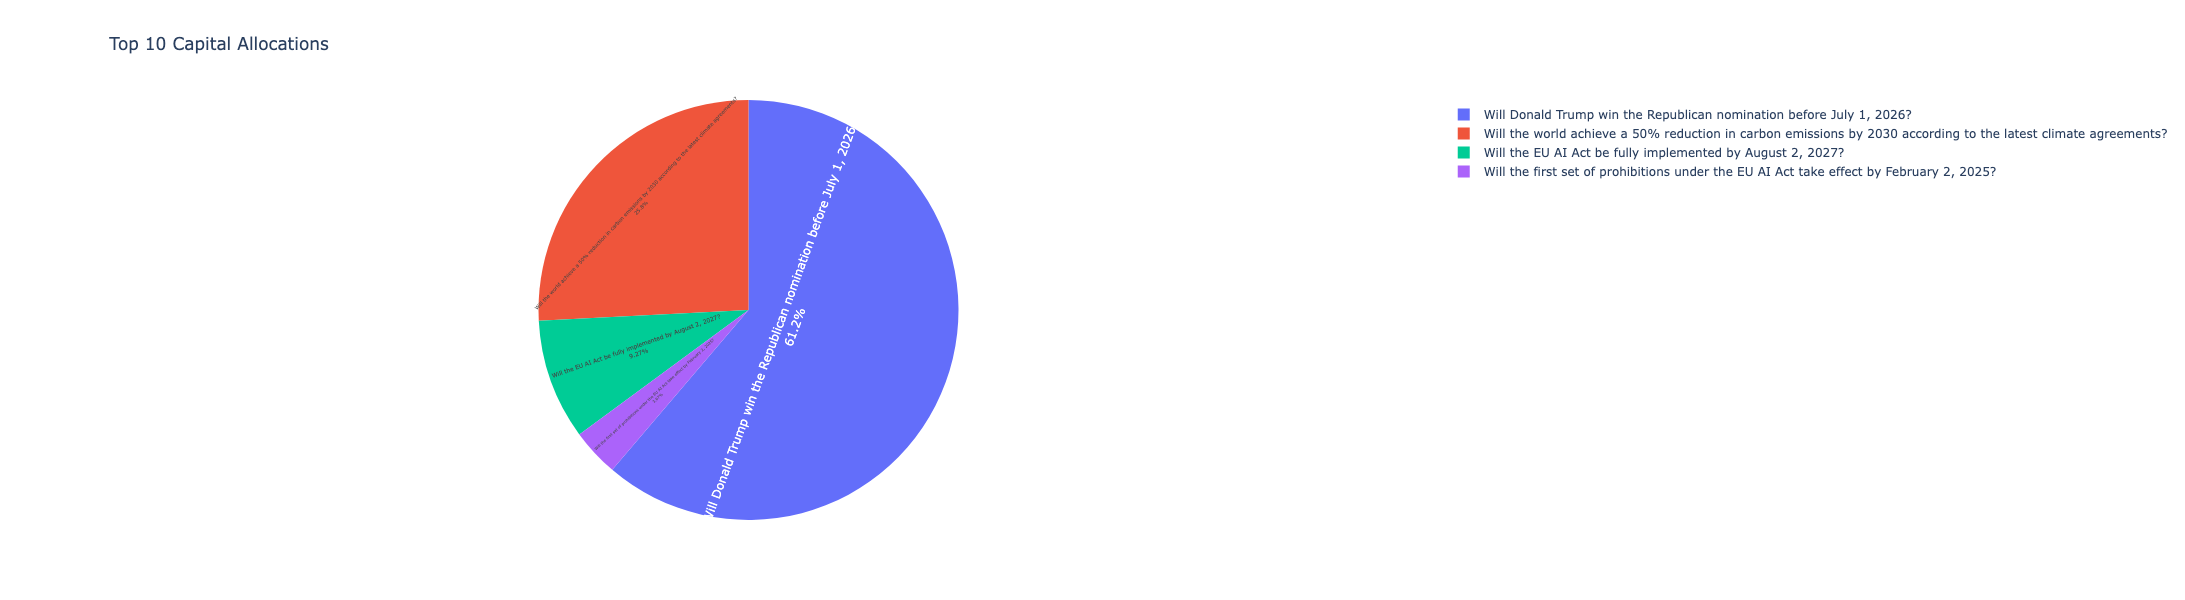

In [10]:
if df is not None and 'allocated_capital' in df.columns:
    # Sort by allocated capital
    df_sorted = df.sort_values('allocated_capital', ascending=False)
    
    print("Top 10 Capital Allocations")
    print("=" * 80)
    for i, row in df_sorted.head(10).iterrows():
        print(f"${row['allocated_capital']:>10,.2f} - {row['question'][:65]}...")
    
    # Create pie chart
    fig = px.pie(
        df_sorted.head(10),
        values='allocated_capital',
        names='question',
        title='Top 10 Capital Allocations',
        height=600
    )
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

### Volume vs Probability

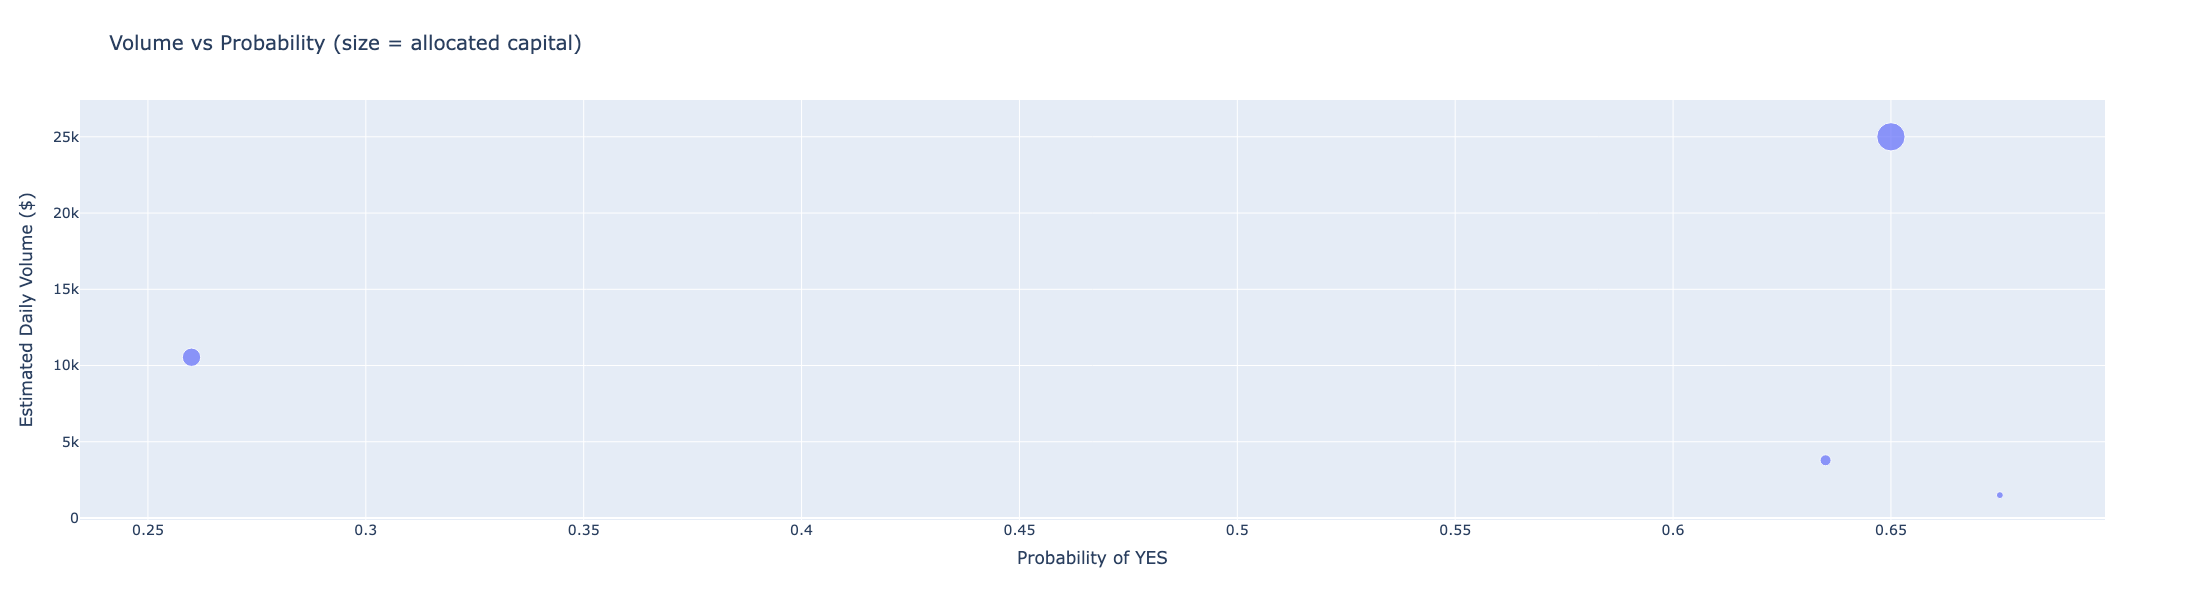

In [11]:
if df is not None and 'estimated_daily_volume' in df.columns and 'probability_mean' in df.columns:
    # Filter out missing values
    df_valid = df.dropna(subset=['estimated_daily_volume', 'probability_mean'])
    
    if len(df_valid) > 0:
        fig = px.scatter(
            df_valid,
            x='probability_mean',
            y='estimated_daily_volume',
            size='allocated_capital',
            hover_data=['question', 'topic'],
            title='Volume vs Probability (size = allocated capital)',
            labels={
                'probability_mean': 'Probability of YES',
                'estimated_daily_volume': 'Estimated Daily Volume ($)'
            },
            height=600,
            width=1000
        )
        fig.update_layout(font=dict(size=14))
        fig.show()
    else:
        print("No valid data for volume vs probability plot")

## Detailed Question View

Display all questions with their complete information.

In [15]:
if df is not None:
    # Select columns to display
    display_cols = ['topic', 'question', 'estimated_daily_volume', 'probability_mean', 
                    'probability_std', 'allocated_capital']
    
    # Filter to available columns
    display_cols = [col for col in display_cols if col in df.columns]
    
    df_display = df[display_cols].copy()
    
    # Format numeric columns
    if 'estimated_daily_volume' in df_display.columns:
        df_display['estimated_daily_volume'] = df_display['estimated_daily_volume'].apply(
            lambda x: f"${x:,.2f}" if pd.notna(x) else "N/A"
        )
    
    if 'allocated_capital' in df_display.columns:
        df_display['allocated_capital'] = df_display['allocated_capital'].apply(
            lambda x: f"${x:,.2f}" if pd.notna(x) else "N/A"
        )
    
    if 'probability_mean' in df_display.columns:
        df_display['probability_mean'] = df_display['probability_mean'].apply(
            lambda x: f"{x:.3f}" if pd.notna(x) else "N/A"
        )
    
    if 'probability_std' in df_display.columns:
        df_display['probability_std'] = df_display['probability_std'].apply(
            lambda x: f"{x:.3f}" if pd.notna(x) else "N/A"
        )
    
    print("All Questions")
    print("=" * 80)
    display(df_display)

All Questions


,topic,question,estimated_daily_volume,probability_mean,probability_std,allocated_capital
0,EU AI Act Implementation,Will the EU AI Act be fully implemented by Aug...,"$3,785.25",0.635,0.045,$927.13
1,EU AI Act Implementation,Will the first set of prohibitions under the E...,"$1,500.00",0.675,0.040,$367.40
2,US Presidential Election Campaigns,Will Donald Trump win the Republican nominatio...,"$25,000.00",0.650,0.032,"$6,123.31"
3,Global Climate Change Initiatives,Will the world achieve a 50% reduction in carb...,"$10,542.37",0.260,0.062,"$2,582.17"


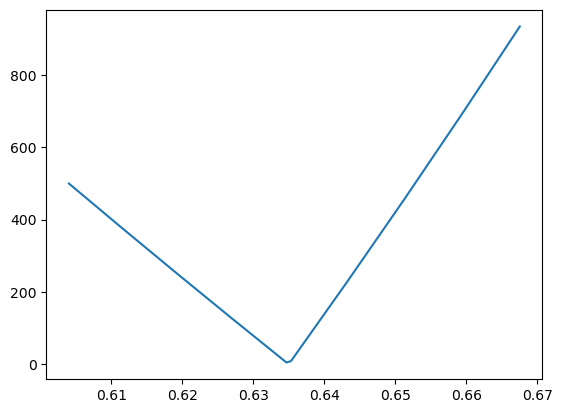

In [31]:
row = df.iloc[0,:]
p = row['probability_mean']
capital = row['allocated_capital']

Q = 1000
B = 10000

yes_schedule, no_schedule = make_market.create_order_price_schedule(p=p, half_spread_bps=5, max_order_bps =500, num_orders=5)

cum_yes_order_cost = make_market.yes_order_schedule(p, Q, yes_schedule,b=B)['cost_cumulative'].values
cum_no_order_cost = make_market.no_order_schedule(p, Q, no_schedule,b=B)['cost_cumulative'].values

lo_prices = np.concatenate([no_schedule[::-1], yes_schedule])
lo_cumsum = np.concatenate([cum_no_order_cost[::-1], cum_yes_order_cost])

plt.plot(lo_prices, lo_cumsum)
plt.show()

In [29]:
p

0.635

## Compare Multiple Runs

Compare results across different pipeline runs.

In [17]:
# Load multiple runs for comparison
if len(runs_df) > 1:
    print("Comparing multiple runs...\n")
    
    comparison_data = []
    for _, run_info in runs_df.head(5).iterrows():  # Compare up to 5 most recent runs
        run_id = run_info['run_id']
        try:
            data = load_pipeline_run(run_id)
            if data['results'] is not None:
                df_run = data['results']
                comparison_data.append({
                    'run_id': run_id,
                    'n_questions': len(df_run),
                    'avg_probability': df_run['probability_mean'].mean() if 'probability_mean' in df_run.columns else None,
                    'avg_volume': df_run['estimated_daily_volume'].mean() if 'estimated_daily_volume' in df_run.columns else None,
                    'total_capital': df_run['allocated_capital'].sum() if 'allocated_capital' in df_run.columns else None,
                })
        except Exception as e:
            print(f"Could not load {run_id}: {e}")
    
    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)
        print("\nComparison of Recent Runs:")
        display(comparison_df)
else:
    print("Only one run available - cannot compare")

Comparing multiple runs...

✓ Loaded results: 4 questions
✓ Loaded full results JSON
✓ Loaded configuration
✓ Loaded summary
✓ Loaded results: 3 questions
✓ Loaded full results JSON
✓ Loaded configuration
✓ Loaded summary
✓ Loaded results: 3 questions
✓ Loaded full results JSON
✓ Loaded configuration
✓ Loaded summary

Comparison of Recent Runs:


,run_id,n_questions,avg_probability,avg_volume,total_capital
0,20251016_1138,4,0.555,10206.905000,10000.0
1,20251016_1134,3,NaN,17333.333333,10000.0
2,20251016_1126,3,NaN,14833.333333,10000.0
